# Modeling Survival Outcome in Time Series Data with Recurrent Neural Networks

The goal of this project is to build a deep neural network that can predict future outcomes based on **time series**, or sequential, data.  

A time series is a series of data points, ordered in time. For complex systems, each data point will likely be **multivariate**, meaning there are multiple variables for each data point.  Examples of data sets with multivariate time series data are electricity demand forecast, financial markets, air quality measurement, and health records.  In each case, the goal is to predict one of the variable values, such as a stock price, pollutant level, or patient outcome, based on the sequential dependence of past data.  

In this project, we build a deep neural network model to predict patient mortality from time series data contained in patient records. 
<br><br>
The purpose of building such a model, is to provide an analytic framework that medical professionals can use to predict patient mortality at any time of interest. Such a solution provides essential feedback to clinicians when trying to assess the impact of treatment decisions, or raise early warning signs to flag at-risk patients in a busy hospital care setting.

This project and patient **electronic health record (EHR)** data are provided by Children's Hospital Los Angeles (CHLA).

## Table of Contents
We will go through the following steps in this project to recreate the CHLA project through a series of steps.  These steps are meant as a practical example of a process we might follow when applying deep neural networks to a time series data.  These steps do not represent an absolute or mechanical approach to using deep neural networks - every project will vary in approach.


1. [Explore the Data with *pandas*](01_ExploreData.ipynb)<br>
    You'll learn how to:
    - Set Up the Environment<br>
    - Load the Data with *pandas*<br>
    - Visualize the Data
    - Save a *pandas* DataFrame
<br><br>
2. [Prepare the Data with *pandas* and *NumPy*](02_PrepareData.ipynb)<br>
    You'll learn how to:
    - Normalize the Data<br>
    - Fill Data Gaps<br>
    - Pad Variable Length Sequences
    - Save a *NumPy* Array
<br><br>
3. [Build a Time Series Data Model with *Keras*](03_BuildModel.ipynb)<br>
    You'll learn how to:
   - Design the LSTM Network Architecture<br>
   - Train the Model<br>
   - Evaluate the Model Using Validation Data<br>
   - Visualize the Results<br>
   - Compare Against Baselines: PRISM3 and PIM2

<a name="01_setup"></a>
## 1 Set Up the Environment
The libraries we need into our Python workspace.  We need *os* for access to the file system,  *NumPy* for fast array math, *pandas* for data management, and  *MatPlotLib* for visualization.<br>

In [1]:
import os
import numpy as np
import pandas as pd              
import matplotlib.pyplot as plt 
import random

import tensorflow.keras as keras
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Masking
from tensorflow.keras.optimizers import RMSprop

# Configure the notebook to display plots
%matplotlib inline

# set up user paths
data_dir = '/dli/task/data/hx_series'
csv_dir = '/dli/task/csv'

Next, specify the file paths in the data folder which contains training and validation datasets stored in HDF5 format: inputs (X) and their associated labels (y).
[HDF5](http://www.hdfgroup.org/) stands for "hierarchical data format version number 5".  

In [2]:
# training data inputs: x and targets: y
x_train_path = os.path.join(data_dir, 'X_train.hdf')
y_train_path = os.path.join(data_dir, 'y_train.hdf')

# validation data inputs: x and targest: y
x_valid_path = os.path.join(data_dir, 'X_test.hdf')
y_valid_path = os.path.join(data_dir, 'y_test.hdf')

<a name="01_pandas"></a>
## - Load the Data with <i>pandas</i>
Finally, we load the data using the *pandas* API for reading in HDF files. Check out the [pandas documentation](http://pandas.pydata.org) for more info.

In [3]:
# It should take less than one minute to load the files
X_train = pd.read_hdf(x_train_path)
y_train = pd.read_hdf(y_train_path)
X_valid = pd.read_hdf(x_valid_path)
y_valid = pd.read_hdf(y_valid_path)
print('data load complete')

data load complete


<a name="01_explore"></a>
## - Visualize the Data
The dataset contains medical treatments and histories of patients collected over time. The dataset used here consists of 10 years worth of patient encounter data in the Pediatric Intensive Care Unit (PICU) at Children's Hospital Los Angeles, curated by the virtual PICU ([vPICU](http://vpicu.net)) team. This dataset contains 1,113,529 observations among 5,000 unique patient encounters. 

This data is an irregular time series of observations consisting of varied numbers of measurements taken over the course of a patient's stay in the PICU. Time between observations can vary from minutes to hours. A simplified diagram of the data can be seen on the right. <br>
Features (measurement types) include:

* **Statics** *(e.g. gender)*
* **Vitals** *(e.g. heart rate)*
* **Labs** *(e.g. glucose)*
* **Interventions** *(e.g. intubation)*
* **Drugs** *(e.g. dopamine)*

In [4]:
X_train

ABG Base excess (mEq/L)  ABG FiO2  ABG HCO3 (mEq/L)  \
encounterID absoluteTime                                                        
8           0.000000                          NaN       NaN               NaN   
            0.250000                          NaN       NaN               NaN   
            0.500000                          NaN       NaN               NaN   
            0.583333                          NaN       NaN               NaN   
            0.750000                          NaN       NaN               NaN   
...                                           ...       ...               ...   
16259       87.000000                         NaN       NaN               NaN   
            87.083336                         NaN       NaN               NaN   
            87.666664                         NaN       NaN               NaN   
            88.000000                         NaN       NaN               NaN   
            89.000000                         NaN       NaN               NaN   

                          ABG O2 sat (%)  ABG PCO2 (mmHg)  ABG PO2 (mmHg)  \
encounterID absoluteTime                                                    
8           0.000000                 NaN              NaN             NaN   
            0.250000                 NaN              NaN             NaN   
            0.500000                 NaN              NaN             NaN   
            0.583333                 NaN              NaN             NaN   
            0.750000                 NaN              NaN             NaN   
...                                  ...              ...             ...   
16259       87.000000                NaN              NaN             NaN   
            87.083336                NaN              NaN             NaN   
            87.666664                NaN              NaN             NaN   
            88.000000                NaN              NaN             NaN   
            89.000000                NaN              NaN             NaN   

                          ABG TCO2 (mEq/L)  ABG pH  ALT (SGPT) (units/L)  \
encounterID absoluteTime                                                   
8           0.000000                   NaN     NaN                   NaN   
            0.250000                   NaN     NaN                   NaN   
            0.500000                   NaN     NaN                   NaN   
            0.583333                   NaN     NaN                   NaN   
            0.750000                   NaN     NaN                   NaN   
...                                    ...     ...                   ...   
16259       87.000000                  NaN     NaN                   NaN   
            87.083336                  NaN     NaN                   NaN   
            87.666664                  NaN     NaN                   NaN   
            88.000000                  NaN     NaN                   NaN   
            89.000000                  NaN     NaN                   NaN   

                          AST (SGOT) (units/L)  ...  Vasopressin  Vecuronium  \
encounterID absoluteTime                        ...                            
8           0.000000                       NaN  ...          NaN         NaN   
            0.250000                       NaN  ...          NaN         NaN   
            0.500000                       NaN  ...          NaN         NaN   
            0.583333                       NaN  ...          NaN         NaN   
            0.750000                       NaN  ...          NaN         NaN   
...                                        ...  ...          ...         ...   
16259       87.000000                      NaN  ...          NaN         NaN   
            87.083336                      NaN  ...          NaN         NaN   
            87.666664                      NaN  ...          NaN         NaN   
            88.000000                      NaN  ...          NaN         NaN   
            89.000000

One thing to note is that in addition to the non-uniform sampling, not all measurement types were taken for all patients.

If we just have a look at the training data, it's clear that we have a collection of patient encounters with a set of variables observed at different times during each encounter.  But again, not all variables are measured at each observation time (row entry). 

The label (y) data for each patient encounter is the ultimate result of alive (1) or not alive (0). 

Let's take a look at the data.

Notice here that there are 265 measurement variables (columns) in total.  We could also ask directly using `len(X_train.columns)`.<br>
The data imported by is a multi-index DataFrame where index "level 0" is the unique patient encounter identifier (`encounterID`) and index "level 1" is the time of each observation in units of hours since the first observation (`absoluteTime`).

We take quick look at the label data for each patient encounter.  We see it follows the same indexing, but only contains a single binary value for each observation.

In [5]:
y_train

mortalityResponse
encounterID absoluteTime                   
8           0.000000                      1
            0.250000                      1
            0.500000                      1
            0.583333                      1
            0.750000                      1
...                                     ...
16259       87.000000                     1
            87.083336                     1
            87.666664                     1
            88.000000                     1
            89.000000                     1

[1113529 rows x 1 columns]

<a name='01_single'></a>
### - View Data from a Single Encounter
We can look more closely at a single patient visit by specifying the `encounterID` "level 0" index.  To extract just these values, try the following:

In [6]:
X_train.index.levels[0]

Int64Index([    8,    11,    13,    15,    18,    20,    21,    23,    25,
               27,
            ...
            16233, 16236, 16241, 16243, 16244, 16248, 16250, 16254, 16255,
            16259],
           dtype='int64', name='encounterID', length=5000)

We select a random patient encounter and extract specific variables and the variety of data associated with various random patients:

In [7]:
# Select a random patient encounterID from a list of all the encounterID values
eIdx = random.choice(list(X_train.index.levels[0]))

# Specify a few variables to look at
variables = [
    'Age','Heart rate (bpm)','PulseOximetry','Weight',
    'SystolicBP','DiastolicBP','Respiratory rate (bpm)',
    'MotorResponse','Capillary refill rate (sec)'
]

# Have a look at the variables for the selected patient
print('encounterID = {}'.format(eIdx))
print('number of observations = {}'.format(X_train.loc[eIdx].index.shape[0]))
print('max absoluteTime value = {} hours'.format(X_train.loc[eIdx].index[-1]))
X_train.loc[eIdx, variables].head()

encounterID = 5327
number of observations = 63
max absoluteTime value = 39.25 hours


,Age,Heart rate (bpm),PulseOximetry,Weight,SystolicBP,DiastolicBP,Respiratory rate (bpm),MotorResponse,Capillary refill rate (sec)
absoluteTime,,,,,,,,,
0.000000,7.280555,113.0,100.0,14.9,103.0,83.0,18.0,NaN,NaN
0.016667,7.280557,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
0.250000,7.280583,109.0,100.0,NaN,106.0,70.0,19.0,NaN,NaN
0.883333,7.280655,100.0,100.0,NaN,NaN,NaN,18.0,NaN,NaN
1.250000,7.280697,111.0,100.0,NaN,101.0,74.0,17.0,NaN,NaN


The number of rows tells us how many observations are included in the patient encounter, and the final `absoluteTime` indicates how many hours long the entire encounter lasted.

To get a look at a variable for a particular patient encounter we can simply extract that variable from an encounter and plot it using a plot function.

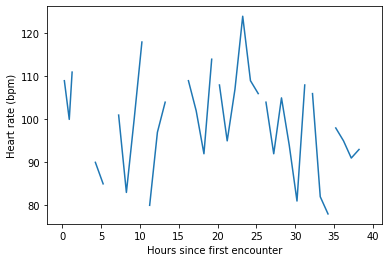

In [8]:
X_train.loc[eIdx, "Heart rate (bpm)"].plot()
plt.ylabel("Heart rate (bpm)")
plt.xlabel("Hours since first encounter")
plt.show()

<a name="01_ex_nobs"></a>
### - Observation Count Histogram
We might want to know more about the variability of the time series data. For example, how many observations are there in an encounter typically?  A histogram will provide a good visualization of how the variability in observations per patient is distributed.  To create a histogram we need to:

1. Create a list of `encounterID` values
2. Create a list of observation counts for each of these encounters
3. Create a histogram using MatplotLib  

In [9]:
# Create a list of `encounterID` values
eIdx_list = X_train.index.levels[0]
print('eIdx_list created of length {} (Sanity check: this length should be 5000)'.format(len(eIdx_list)))

eIdx_list created of length 5000 (Sanity check: this length should be 5000)


In [10]:
# Create a list of observation counts for each of these encounters
nobs_list = [X_train.loc[ix].index.shape[0] for ix in eIdx_list]
print('list of observation counts created of length {} (Sanity check: this length should also be 5000)'.format(len(nobs_list)))

list of observation counts created of length 5000 (Sanity check: this length should also be 5000)


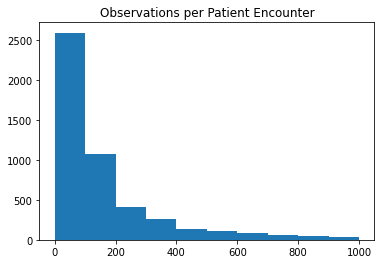

In [11]:
# Create a histogram using MatplotLib
plt.hist(nobs_list,range=(0,1000))
plt.title("Observations per Patient Encounter")
plt.show()

Now you can also check the mean and median counts using `np.mean()` and `np.median()` functions over the list. 

In [12]:
print('The mean = {}'.format(np.mean(nobs_list)))
print('The median = {}'.format(np.median(nobs_list)))

The mean = 222.7058
The median = 94.0


<a name='01_ex_time'></a>
### - Length of PICU Stay Histogram
We can do a similar analysis to determine the observation timespan over all patient encounters.  Recall that the observation index `absoluteTime` is the cumulative time since admission to the PICU.  Therefore, the last `absoluteTime` value is the one we want to capture for each encounter.  
1. Create a list of `encounterID` values
2. Create a list of `absoluteTime` final for each encounter
3. Create a histogram using MatplotLib  

In [13]:
# Create a list of `encounterID` values
eIdx_list = X_train.index.levels[0]
print('eIdx_list created of length {} (Sanity check: this length should be 5000)'.format(len(eIdx_list)))

eIdx_list created of length 5000 (Sanity check: this length should be 5000)


In [14]:
# Create a list of `absoluteTime` final for each encounter
timespan_list = [X_train.loc[ix].index[-1] for ix in eIdx_list]
print('timespan_list created of length {} (Sanity check: this length should be 5000)'.format(len(timespan_list)))

timespan_list created of length 5000 (Sanity check: this length should be 5000)


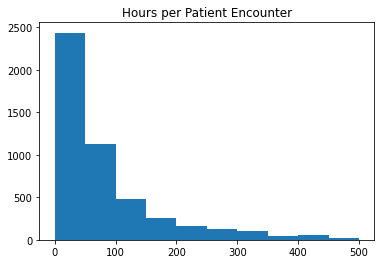

In [15]:
# Create a histogram using MatplotLib
plt.hist(timespan_list,range=(0,500))
plt.title("Hours per Patient Encounter")
plt.show()

Now you can also check the mean and median counts using `np.mean()` and `np.median()` functions over the list. 

<a name="01_save"></a>
## - Save a *pandas* DataFrames
Save the *pandas* DataFrames to reload into the next step.

In [16]:
# Save the DataFrame's for use in other notebooks
X_train.to_pickle('X_train.pkl')
y_train.to_pickle('y_train.pkl')
X_valid.to_pickle('X_valid.pkl')
y_valid.to_pickle('y_valid.pkl')

<a name="02_prepare"></a>
# 2. Prepare the Data with *pandas* and *NumPy*
<hr>
The initial data, in its raw form, includes variabilities that will become problematic when we process it through a model to find patterns.  The variabilities in the data that we want to mitigate are:

* Measurement values have widely varying ranges that require normalization
* Not every measurement is taken during every observation, resulting in data gaps
* The number of observations per encounter varies widely

Here we introduce techniques to address these concerns and prepare the data for training.

- [**Normalize the Data**](#02_normalize)<br>
- [**Fill Data Gaps**](#02_gaps)<br>
- [**Pad Variable Length Sequences**](#02_pad)<br>
&nbsp; &nbsp; &nbsp;- [Padded Variable over all Patient Encounters](#02_ex_pad)<br>
- [**Save a *NumPy* Array**](#02_save)<br>

In [17]:
# Fetch the DataFrame's loaded in the problem setup
X_train=pd.read_pickle('X_train.pkl')
y_train=pd.read_pickle('y_train.pkl')
X_valid=pd.read_pickle('X_valid.pkl')
y_valid=pd.read_pickle('y_valid.pkl')

<a name="02_normalize"></a>
## - Normalize the Data
We normalize each observed feature / variable by subtracting its mean and dividing the result by the standard deviation.  

Why?

We want small variations in one variable to be treated with the same emphasis as HUGE variations of another. Keep in mind that the network just sees a bunch of numbers - it doesn't actually "know" anything about predictors, factors, variables, obervations and so on and so forth. Emperically, normalization seems to facilitate training but this kind of normalization is probably not appropriate for multimodal data (or non-Gaussian data in general).

Lets take a look at both before and after normalization of a single encounter example:

In [18]:
# Before normalization
X_train.loc[8,['Age','Heart rate (bpm)','PulseOximetry','Weight',
    'SystolicBP','DiastolicBP','Respiratory rate (bpm)',
    'MotorResponse','Capillary refill rate (sec)']]

,Age,Heart rate (bpm),PulseOximetry,Weight,SystolicBP,DiastolicBP,Respiratory rate (bpm),MotorResponse,Capillary refill rate (sec)
absoluteTime,,,,,,,,,
0.000000,7.573383,107.0,100.0,25.0,NaN,NaN,19.0,NaN,NaN
0.250000,7.573411,98.0,100.0,NaN,NaN,NaN,31.0,NaN,NaN
0.500000,7.573440,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.583333,7.573450,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.750000,7.573468,103.0,100.0,NaN,130.0,92.0,37.0,6.0,3.0
...,...,...,...,...,...,...,...,...,...
150.500000,7.590551,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
150.750000,7.590580,94.0,100.0,25.0,121.0,88.0,14.0,6.0,2.0
150.766663,7.590582,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
# create file path for csv file with metadata about variables
metadata = os.path.join(csv_dir, 'ehr_features.csv')

# read in variables from csv file (using pandas) since each varable there is tagged with a category
variables = pd.read_csv(metadata, index_col=0)

# next, select only variables of a particular category for normalization
normvars = variables[variables['type'].isin(['Interventions', 'Labs', 'Vitals'])]

# finally, iterate over each variable in both training and validation data
for vId, dat in normvars.iterrows():
    
    X_train[vId] = X_train[vId] - dat['mean']
    X_valid[vId] = X_valid[vId] - dat['mean']
    X_train[vId] = X_train[vId] / (dat['std'] + 1e-12)
    X_valid[vId] = X_valid[vId] / (dat['std'] + 1e-12)

Take a quick look at some the updated data for a single encounter.

In [20]:
# After normalization
X_train.loc[8,['Age','Heart rate (bpm)','PulseOximetry','Weight',
    'SystolicBP','DiastolicBP','Respiratory rate (bpm)',
    'MotorResponse','Capillary refill rate (sec)']]

,Age,Heart rate (bpm),PulseOximetry,Weight,SystolicBP,DiastolicBP,Respiratory rate (bpm),MotorResponse,Capillary refill rate (sec)
absoluteTime,,,,,,,,,
0.000000,7.573383,-0.429630,0.805317,-10.577633,NaN,NaN,-0.928604,NaN,NaN
0.250000,7.573411,-0.986894,0.805317,NaN,NaN,NaN,1.122353,NaN,NaN
0.500000,7.573440,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.583333,7.573450,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.750000,7.573468,-0.677303,0.805317,NaN,2.087398,3.242043,2.147832,1.240359,2.887591
...,...,...,...,...,...,...,...,...,...
150.500000,7.590551,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
150.750000,7.590580,-1.234567,0.805317,-10.577633,1.305183,2.874280,-1.783170,1.240359,-1.101130
150.766663,7.590582,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<a name="02_gaps"></a>
## - Fill Data Gaps
Having normalized the data, we still need to fill in all the data gaps since not every variable was observed during each observation in the patient encounter.  For example, lets take a look at the gaps in a "Heart rate" encounter by plotting it.

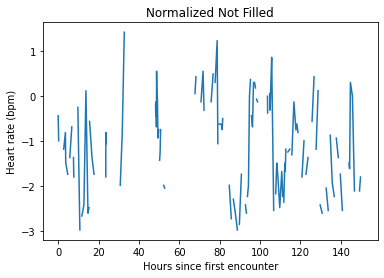

In [21]:
# Before filling gaps
X_train.loc[8, "Heart rate (bpm)"].plot()
plt.title("Normalized Not Filled")
plt.ylabel("Heart rate (bpm)")
plt.xlabel("Hours since first encounter")
plt.show()

Filling in the gaps of missing data is a very active area of research and there is currently no standard practice for time series analysis using deep learning.  For this project, we will simply forward fill existing measurements for each patient, and fill any variable entries with no previous measurement to 0.

In [22]:
# first select variables which will be filled in
fillvars = variables[variables['type'].isin(['Vitals', 'Labs'])].index

# next forward fill any missing values with more recently observed value
X_train[fillvars] = X_train.groupby(level=0)[fillvars].ffill()
X_valid[fillvars] = X_valid.groupby(level=0)[fillvars].ffill()

# finally, fill in any still missing values with 0 (i.e. values that could not be filled forward)
X_train.fillna(value=0, inplace=True)
X_valid.fillna(value=0, inplace=True)

Now lets have a look at the "Heart rate" variable after data normalization and missing values have been filled in.

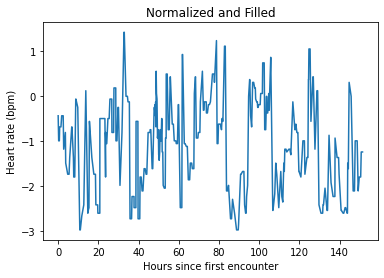

In [23]:
# After filling gaps
X_train.loc[8, "Heart rate (bpm)"].plot()
plt.title("Normalized and Filled")
plt.ylabel("Heart rate (bpm)")
plt.xlabel("Hours since first encounter")
plt.show()

Also, try dumping the X_train vector to the screen again and you will see that all those NaN values have been filled in with zeros.

In [24]:
X_train

ABG Base excess (mEq/L)  ABG FiO2  ABG HCO3 (mEq/L)  \
encounterID absoluteTime                                                        
8           0.000000                     0.000000  0.000000          0.000000   
            0.250000                     0.000000  0.000000          0.000000   
            0.500000                     0.000000  0.000000          0.000000   
            0.583333                     0.000000  0.000000          0.000000   
            0.750000                     0.000000  0.000000          0.000000   
...                                           ...       ...               ...   
16259       87.000000                    2.335037 -1.770313          2.569377   
            87.083336                    2.335037 -1.770313          2.569377   
            87.666664                    2.335037 -1.770313          2.569377   
            88.000000                    2.335037 -1.770313          2.569377   
            89.000000                    2.335037 -1.770313          2.569377   

                          ABG O2 sat (%)  ABG PCO2 (mmHg)  ABG PO2 (mmHg)  \
encounterID absoluteTime                                                    
8           0.000000            0.000000         0.000000          0.0000   
            0.250000            0.000000         0.000000          0.0000   
            0.500000            0.000000         0.000000          0.0000   
            0.583333            0.000000         0.000000          0.0000   
            0.750000            0.000000         0.000000          0.0000   
...                                  ...              ...             ...   
16259       87.000000          -2.668261         0.925765         -1.7796   
            87.083336          -2.668261         0.925765         -1.7796   
            87.666664          -2.668261         0.925765         -1.7796   
            88.000000          -2.668261         0.925765         -1.7796   
            89.000000          -2.668261         0.925765         -1.7796   

                          ABG TCO2 (mEq/L)    ABG pH  ALT (SGPT) (units/L)  \
encounterID absoluteTime                                                     
8           0.000000              0.000000  0.000000                   0.0   
            0.250000              0.000000  0.000000                   0.0   
            0.500000              0.000000  0.000000                   0.0   
            0.583333              0.000000  0.000000                   0.0   
            0.750000              0.000000  0.000000                   0.0   
...                                    ...       ...                   ...   
16259       87.000000             2.385686  0.845536                   0.0   
            87.083336             2.385686  0.845536                   0.0   
            87.666664             2.385686  0.845536                   0.0   
            88.000000             2.385686  0.845536                   0.0   
            89.000000             2.385686  0.845536                   0.0   

                          AST (SGOT) (units/L)  ...  Vasopressin  Vecuronium  \
encounterID absoluteTime                        ...                            
8           0.000000                       0.0  ...          0.0         0.0   
            0.250000                       0.0  ...          0.0         0.0   
            0.500000                       0.0  ...          0.0         0.0   
            0.583333                       0.0  ...          0.0         0.0   
            0.750000                       0.0  ...          0.0         0.0   
...                                        ...  ...          ...         ...   
16259       87.000000                      0.0  ...          0.0         0.0   
            87.083336                      0.0  ...          0.0         0.0   
            87.666664                      0.0  ...          0.0         0.0   
            88.000000                      0.0  ...          0.0         0.

One more thing to note, is that so far we've kept the data set as a pandas DataFrame type. In the next part, we will change it to a NumPy array. You can check this as follows:

In [25]:
type(X_train)

pandas.core.frame.DataFrame

<a name="02_pad"></a>
## - Pad Variable Length Sequences
The final data preparation task is to pad every patient encounter so that all encounters have the same number of observations. 
Note from the histogram, that there are many encounters with less than 100 observation vectors. Therefore, we are going to zero pad each encounter (i.e. insert rows of zeros).

In [26]:
# max number of sequence length
maxlen = 500

# get a list of unique patient encounter IDs
teId = X_train.index.levels[0]
veId = X_valid.index.levels[0]

# pad every patient sequence with 0s to be the same length, 
# then transforms the list of sequences to one numpy array
# this is for efficient minibatching and GPU computations 
X_train = [X_train.loc[patient].values for patient in teId]
y_train = [y_train.loc[patient].values for patient in teId]

X_train = sequence.pad_sequences(X_train, dtype='float32', maxlen=maxlen, padding='post', truncating='post')
y_train = sequence.pad_sequences(y_train, dtype='float32', maxlen=maxlen, padding='post', truncating='post')

# repeat for the validation data

X_valid = [X_valid.loc[patient].values for patient in veId]
y_valid = [y_valid.loc[patient].values for patient in veId]

X_valid = sequence.pad_sequences(X_valid, dtype='float32', maxlen=maxlen, padding='post', truncating='post')
y_valid = sequence.pad_sequences(y_valid, dtype='float32', maxlen=maxlen, padding='post', truncating='post')

We have performed the following: 

1. We converted the _pandas_ DataFrame into a Python list, which contained lists of values (a list of list of values).  
2. Using  `keras.preprocessing.sequence.pad_sequences`, we converted the value lists into a `numpy.array` of type `float32`, having a maximum length of 500.  
3. If the patient encounter didn't have 500 encounters (most don't, see previous histogram) then we apply `padding='post'`, which says to pad with zeros.  That is, add extra rows (observation vectors) of all zeros.
4. The option `truncating='post'` just says: if there are more than 500 observations, then take the first 500 and drop everything after.  

Together, this says: **force patient encounter records of dimension 500x265 and use zero padding to inflate the size if needed**.  

In [27]:
# print the shape of the array which will be used by the network
# the shape is of the form (# of encounters, length of sequence, # of features)
print("X_train shape: %s | y_train shape: %s" % (str(X_train.shape), str(y_train.shape)))
print("X_valid shape: %s | y_valid shape: %s" % (str(X_valid.shape), str(y_valid.shape)))

X_train shape: (5000, 500, 265) | y_train shape: (5000, 500, 1)
X_valid shape: (2690, 500, 265) | y_valid shape: (2690, 500, 1)


Note that the type of X_train has changed to ```numpy.ndarray```:

In [28]:
type(X_train)

numpy.ndarray

Now we can plot the full patient encounter as a matrix plot. 

ix = 4653


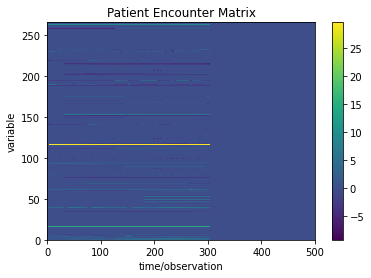

In [29]:
# figure out how many encounters we have
numencnt = X_train.shape[0]

# choose a random patient encounter to plot
ix = random.randint(0,5000) #Try a few different index values between 0 and 4999
print('ix = {}'.format(ix))

# plot a matrix of observation values
plt.title("Patient Encounter Matrix")
plt.pcolor(np.transpose(X_train[ix,:,:]))
plt.ylabel("variable")
plt.xlabel("time/observation")
plt.ylim(0,265)
plt.colorbar()
plt.show()

We need to keep in mind here that these data are zero padded by ```sequence.pad_sequences```. These matricies are what will be fed as input into the LSTM model for training. Notice that we can plot a variable in a similar fashion by selecting along the third axis instead of the first axis. This provides a view of a particular variable over all patient encounters.
<a name='02_ex_pad'></a>
### - Padded Variable over all Patient Encounters
Visualize a particular variable across all encounters with the following steps.  
1. Choose a variable to examine 
2. Create a matrix of encounters vs time/observation
3. Plot the matrix

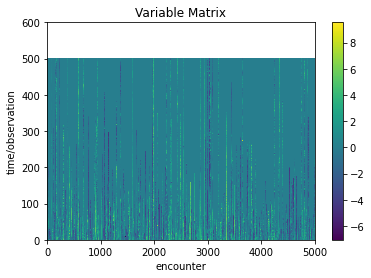

In [30]:
varnum = 115 

# Create a matrix of encounters vs time/observation
varmatrix = np.transpose(X_train[:,:,varnum])

# Plot the matrix
try:
    plt.title("Variable Matrix")
    plt.pcolor(varmatrix) 
    plt.ylabel("time/observation")
    plt.xlabel("encounter")
    plt.ylim(0,600)
    plt.colorbar()
    plt.show()
except Exception as e:
    print('ERROR found: {}'.format(e))

<a name="02_save"></a>
## - Save a *NumPy* Arrays

In [31]:
# Save the prepared numpy arrays for use in other notebooks
np.save('X_train_prepared.npy',X_train,allow_pickle=False)
np.save('y_train_prepared.npy',y_train,allow_pickle=False)
np.save('X_valid_prepared.npy',X_valid,allow_pickle=False)
np.save('y_valid_prepared.npy',y_valid,allow_pickle=False)

<a name="02_prepare"></a>
# 3. Build a Time Series Data Model with Keras
<hr>
Here, we construct and train a neural network using _Keras_ that can ingest the prepared data and make a prediction at each timestep of the patient's probability of survival.  We then compare its accuracy against industry baseline models.

- [**Design the LSTM Network Architecture**](#03_construct)<br>
&nbsp; &nbsp; &nbsp;- [Recurrent Neural Network Models](#03_rnn)<br>
&nbsp; &nbsp; &nbsp;- [Construct an LSTM Network with *Keras*](#03_lstm)<br>
&nbsp; &nbsp; &nbsp;- [Model Architecture Decisions](#03_decisions)<br>
- [**Train the Model**](#03_train)<br>
- [**Evaluate the Model Using Validation Data**](#03_evaluate)<br>
- [**Visualize the Results**](#03_visualize)<br>
- [**Compare the Baseline to PRISM3 and PIM2**](#03_compare)<br>
- [**Conclusion**](#03_conclusion)<br>
&nbsp; &nbsp; &nbsp;<br>

First, import the libraries for the new notebook
We also need to reload the data saved at the end of the previous notebook as `.npy` (_NumPy array_) files.

In [32]:
# Fetch the DataFrame's loaded in the problem setup
X_train=np.load('X_train_prepared.npy')
y_train=np.load('y_train_prepared.npy')
X_valid=np.load('X_valid_prepared.npy')
y_valid=np.load('y_valid_prepared.npy')

<a name="03_construct"></a>
## - Design the LSTM Network Architecture
Traditional deep neural networks, such as those that might be used to classify images, include no memory of the past.  In time series problems like our prediction project, we need a special type of neural network that includes past information as part of its input.

<a name="03_rnn"></a>
### - Recurrent Neural Network Models

A **recurrent neural network** ([RNN](https://developer.nvidia.com/discover/recurrent-neural-network)) is a class of artificial neural network that has memory in the form of feedback loops. The **recurrent connections** in the RNN architecture provide visibility of not just the current data sample, but also the network's previous hidden state. A recurrent network with a feedback loop can be visualized as multiple copies of a neural network, with the output of one serving as an input to the next in time. An RNN is particularly useful when a sequence of data is being processed to make a classification decision or regression estimate, though it can also be used on non-sequential data. Recurrent neural networks are typically used to solve tasks related to time series data. 

In theory, RNNs can make use of information in arbitrarily long sequences.  In practice, RNNs are limited to looking back only a few steps due to what is called the [**vanishing gradient**](https://en.wikipedia.org/wiki/Vanishing_gradient_problem) problem.  In essence, during the training process, as errors are backpropagated through time, inputs from previous time steps get exponentially down-weighted and are eventually driven to zero (i.e. vanish).

In this project we use a variant of the RNN called the [**long short-term memory** (LSTM)](https://en.wikipedia.org/wiki/Long_short-term_memory). LSTMs solve the vanishing gradient problem by augmenting the network with recurrent gates called [**forget gates**](http://www.jmlr.org/papers/volume3/gers02a/gers02a.pdf). A defining feature of the LSTM is that it prevents backpropagated errors from vanishing (or exploding) and instead allows errors to flow backwards through unlimited numbers of "virtual layers" unfolded in time. That is, the LSTM can learn "[very deep](https://arxiv.org/abs/1404.7828)" tasks that require memories of events that happened thousands or even millions of discrete time steps ago. Problem-specific LSTM-like topologies can be [evolved](http://link.springer.com/chapter/10.1007/978-3-642-04277-5_76) and can work even when signals contain long delays or have a mix of low and high frequency components.

<a name="03_lstm"></a>
### - Construct an LSTM Network with *Keras*
We will construct our LSTM network with [_Keras_](https://keras.io). _Keras_ is a high-level neural networks API, written in Python, and capable of running on top of various backend frameworks on CPUs and GPUs.  For this lab, we are running _Keras_ on the [_TensorFlow 2_](https://www.tensorflow.org/api_docs/python/tf/keras) framework.

At each time step,the measurements recorded from an encounter will be used as input to the network, and a probability of survival prediction will be generated. Note that this enables a real-time monitor of the patient's probability of survival and insight into the patient's trajectory, because there is a new prediction on the output every time a new observation is added to the input into the system

In [33]:
# construct inputs
x = Input((None, X_train.shape[-1]) , name='input')
mask = Masking(0, name='input_masked')(x)

# stack LSTMs
lstm_kwargs = {'dropout': 0.25, 'recurrent_dropout': 0.1, 'return_sequences': True, 'implementation': 2}
lstm1 = LSTM(128, name='lstm1', **lstm_kwargs)(mask)

# output: sigmoid layer
output = TimeDistributed(Dense(1, activation='sigmoid'), name='output')(lstm1)
model = Model(inputs=x, outputs=output)

# compile model
optimizer = RMSprop(lr=0.005)
model.compile(optimizer=optimizer, loss='binary_crossentropy')

# print layer shapes and model parameters
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, None, 265)]       0         
_________________________________________________________________
input_masked (Masking)       (None, None, 265)         0         
_________________________________________________________________
lstm1 (LSTM)                 (None, None, 128)         201728    
_________________________________________________________________
output (TimeDistributed)     (None, None, 1)           129       
Total params: 201,857
Trainable params: 201,857
Non-trainable params: 0
_________________________________________________________________


<a name="03_decisions"></a>
### - Model Architecture Decisions

We created a single LSTM.  The input is sized based on the number of variables in an observation (265) for our data.  There are a number of parameters required in the definition of the architecture, requiring design decisions as follows:
 
**Binary cross entropy loss function** (`binary_crossentropy`) is used to calculate the difference between the calculated and actual results during training, because it is the theoretically optimal cost function for a binary classification problem (in this case, mortality). However, occasionally the Mean Squared Error (MSE) cost function is used since it tends to be a bit more stable numerically.

The Mean Squared Error (MSE) is a common metric used in statistics and machine learning to measure the average squared differences between predicted and actual observations. It's often used in regression analysis and essentially measures the average squared error of our predictions. For each point, it calculates the square difference between the predictions and the target and then averages these values.

The formula to compute the MSE of an estimator (a function for guessing unknown parameters, for instance) is:

MSE = (1/n) * Σ(actual - prediction)² 

Here:
- n is the total number of observations or data points.
- The Σ symbol indicates summation, i.e., the sum of the results for each data point.
- (actual - prediction)² is the square of the difference between the actual value and the predicted value.

The MSE is always non-negative, and a value of 0 indicates a perfect fit to the data. In general, a lower MSE means a better fit of the model to the data. However, one needs to be careful as a too low MSE could also indicate overfitting, where the model learns the training data too well and performs poorly on unseen (test) data.
 
**Dropout** (`dropout`) is used to randomly drop a percentage of elements of the input vector (It drops the same elements of the vector for every time step of the sequence). This forces the network to leverage information contained in potentially covariate variables.  For example, a particular sample Heart Rate may be ‘dropped’, but a combination of systolic/diastolic blood pressure and breathing rate may provide a reasonable proxy.
 
**Recurrent dropout** (`recurrent_dropout`) is the fraction of the units to drop for the linear transformation of the recurrent state.  This is used for similar reasons to traditional dropout in CNNs. It forces the network to utilize all of the hidden nodes such that too much information is not contained in a single hidden unit. In practice this tends to lead to more stable networks.
 
**RMSprop** optimizer is selected because it is a good general optimizer for LSTMs.  See [here](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) for more details.  
 
**Learning Rate** (`lr=0.005`) value selected to find a reasonable local minimum within a small number of training epochs for time consideration.  Typically one would likely use an even smaller LR and allow the network to take smaller ‘learning steps’, but that choice requires more training rounds to converge (i.e. slower training).
 
As always with neural networks, there was some amount of hyper-parameter tuning.  It is important to keep in mind that this network has not been optimally tuned.  A handful of reasonable default values were chosen to create a state-of-the-art mortality predictor in the least amount of GPU cycles possible (for tutorial purposes).

Read the [docs](https://keras.io/layers/core/) for more information on core layers in _Keras_. 

<a name="03_train"></a>
## - Train the Model
Now, lets feed some data into the network for training. Our objective is to train the model on past sequential known data so that we can use the model as a predictor on new data.  

We use a batch size of 128 which means that we update parameters every 128 time steps.  He we use only 5 training **epochs**, which means that we run through the entire data set 5 times.  Finally, the verbose option just says to produce status / summary information during the training.

In [34]:
# this will take a while...
history = model.fit(X_train, y_train, batch_size=128, epochs=5, verbose=1)

Train on 5000 samples
Epoch 1/5
5000/5000 [==============================] - 52s 10ms/sample - loss: 0.0842
Epoch 2/5
5000/5000 [==============================] - 49s 10ms/sample - loss: 0.0684
Epoch 3/5
5000/5000 [==============================] - 49s 10ms/sample - loss: 0.0634
Epoch 4/5
5000/5000 [==============================] - 49s 10ms/sample - loss: 0.0600
Epoch 5/5
5000/5000 [==============================] - 49s 10ms/sample - loss: 0.0573


<a name="03_evaluate"></a>
## - Evaluate the Model Using Validation Data
Our first task in evaluating the model performance is to predict mortality using the hold out dataset (i.e. validation data).

In [35]:
# Generate model results on the holdout validation set
preds = model.predict(X_valid)

We notice that size of the predictions. The validation set is smaller than the 5000 encounters we used for the training set.

In [36]:
preds.shape

(2690, 500, 1)

<a name="03_visualize"></a>
## - Visualize the Results
We have 2,690 patient encounters for testing, and at each of the observations the model predicts survivability.  Lets plot some predictions!

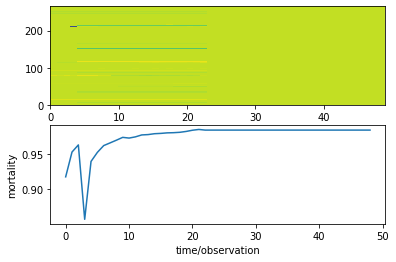

In [37]:
# Figure out how many encounters we have
numencnt = X_valid.shape[0]

# Choose a random patient encounter to plot
ix = random.randint(0,numencnt-1)

# Create axis side by side
f, (ax1, ax2) = plt.subplots(2, 1)

# Plot the observation chart for the random patient encounter
ax1.pcolor(np.transpose(X_valid[ix,1:50,:]))
ax1.set_ylim(0,265)
plt.ylabel("mortality")
plt.xlabel("time/observation")

# Plot the patient survivability prediction
ax2.plot(preds[ix,1:50]);

<a name="03_compare"></a>
## - Compare Against Baselines: PRISM3 and PIM2

Both PIM2 and PRISM3 are scoring systems for ICU and surgical patients.  Models that predict the risk of death of groups of patients admitted to intensive care are available for adult, pediatric and neonatal intensive care. By adjusting for differences in severity of illness and diagnosis, these models can be used to compare the standard of care between units and within units over time. They can also be used to compare different methods of organising intensive care. Estimating mortality risk is also an important component of comparing groups of patients in research trials.  
  
For details, see Pediatric Risk of Mortality ([PRISM](http://www.ncbi.nlm.nih.gov/pubmed/3048900))  and <a href="http://www.jpeds.com/article/S0022-3476(97)70065-9/abstract">PRISM3</a>.

First, we compute the **Receiver Operating Characteristic** ([ROC](http://gim.unmc.edu/dxtests/roc2.htm)) information for the predictions from our model so we can compare it to the baseline models.

A Receiver Operating Characteristic (ROC) is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. 

The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings. The true positive rate is also known as sensitivity, recall, or probability of detection. The false positive rate is also known as the probability of false alarm and can be calculated as (1 - specificity). 

The area under the ROC curve (AUC-ROC) is a measure of how well a parameter can distinguish between two diagnostic groups (diseased/normal). AUC values range from 0 to 1, where a value of 0.5 suggests no discrimination (i.e., ability to distinguish the classes is no better than chance), and a value of 1 indicates perfect discrimination.

The ROC curve is widely used in many fields like medicine, radiology, natural language processing, machine learning, and data mining to measure the performance of classification algorithms.

First, we compute the **Receiver Operating Characteristic** ([ROC](http://gim.unmc.edu/dxtests/roc2.htm)) information for the predictions from our model so we can compare it to the baseline models.

In [38]:
from sklearn.metrics import roc_curve, auc

# get 0/1 binary label for each patient encounter
label = y_valid[:, 0, :].squeeze();

# get the last prediction in [0,1] for the patient
prediction = preds[:, -1, :].squeeze()

# compute ROC curve for predictions
rnn_roc = roc_curve(label,prediction)

# compute the area under the curve of prediction ROC
rnn_auc = auc(rnn_roc[0], rnn_roc[1])

Next, we extract precompute PIM2 and PRISM3 estimates from a CSV file.

In [39]:
# scores for baselines PRISM3 and PIM2 were aggregated and stored in `data/pim2prism3.csv`.
# load the scores and then compute the ROC curves and AUC
index = pd.read_csv(os.path.join('/dli/task/csv', 'pim2prism3.csv'))

# get the mortality reponse for each patient
mortrep = index['mortalityResponse'];

# generate ROC curves for each index
pim2_roc   = roc_curve(mortrep, -index['PIM2'  ])
prism3_roc = roc_curve(mortrep, -index['PRISM3'])

# compute the area under the curve for each index
pim2_auc   = auc(  pim2_roc[0],   pim2_roc[1])
prism3_auc = auc(prism3_roc[0], prism3_roc[1])

Let's now plot these two ROC curves against our RNN model results curve for comparison.

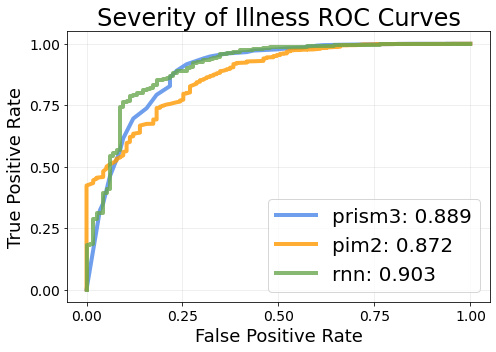

In [40]:
# plot rocs & display AUCs
plt.figure(figsize=(7, 5))
line_kwargs = {'linewidth': 4, 'alpha': 0.8}
plt.plot(prism3_roc[0], prism3_roc[1], label='prism3: %0.3f' % prism3_auc, color='#4A86E8', **line_kwargs)
plt.plot(pim2_roc[0], pim2_roc[1], label='pim2: %0.3f' % pim2_auc, color='#FF9900', **line_kwargs)
plt.plot(rnn_roc[0], rnn_roc[1], label='rnn: %0.3f' % rnn_auc, color='#6AA84F', **line_kwargs)
plt.legend(loc='lower right', fontsize=20)
plt.xlim((-0.05, 1.05))
plt.ylim((-0.05, 1.05))
plt.xticks([0, 0.25, 0.5, 0.75, 1.0], fontsize=14)
plt.yticks([0, 0.25, 0.5, 0.75, 1.0], fontsize=14)
plt.xlabel("False Positive Rate", fontsize=18)
plt.ylabel("True Positive Rate", fontsize=18)
plt.title("Severity of Illness ROC Curves", fontsize=24)
plt.grid(alpha=0.25)
plt.tight_layout()

Our model is performing well, considering we only did a few rounds of training!

<a name="03_conclusion"></a>
## -  Conclusion
RNNs provide a method to quickly extract clinically significant information and insights from available EHR data.

The amount of data, model complexity, number of features, and number of epochs have been reduced in this tutorial to  reduce computational burden.  The examples below display the performance of a fully trained RNN on a larger dataset.  They also show the performance of PIM2 and PRISM3, two standard scoring systems,  as well as the performance of a logistic regression model and a multi-layer perceptron (MLP).  

The temporally dynamic nature of the RNN enables it to extract more information from the underlying EHR than an MLP.  The MLP's complexity is similar to the RNN's, but the former is limited to instantaneous information.

The graph above shows the temporal trajectory of the fully trained RNN's probability of survival predictions. The capability to provide a prediction at any timestep of interest provides valuable feedback to a clinician working to asses the impact of treatment decisions.   